# Effect of straylight subtraction on MRS extended source observations
The third calibration step in the baseline MRS calibration pipeline (after assigning WCS information and applying the pixel flat), is the straylight subtraction. This step comes before the fringe correction and the flux calibration.  
  
In this notebook we use the method of straylight subtraction (version 2) developed by Adrian Glauser and Polychronis Patapis at ETH Zurich (see MIRI-TN-00003-ETH-1.0_MRS_straylight). We check what the impact of the correction is on data of an 800K BB extended source observed during testing carried out at RAL (MIRI FM test campaign).

In [13]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
from astropy.io import fits
from scipy.interpolate import splrep,BSpline
from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

We load an MRS image of a optical stimulus observed in one of the MRS nominal spectral bands. In this case the source is the:  
* MTS 800K BB extended source, observed in spectral bands 1A/2A

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

# load detector2cube (d2c) distortion maps
band     = '1A'
d2cMaps  = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir) # here, d2c stands for detector to cube transformation, from x,y integer pixel coordinates, to alpha, beta, and wavelength coordinates
sliceMap = d2cMaps['sliceMap']     # map with slice IDs
det_dims = (1024,1032)             # pixel dimensions of the detector

# Get data
ext_source_scifile,ext_source_bkgfile = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='400K',output='filename')
ext_source_sci,ext_source_bkg = fits.open(ext_source_scifile)[0].data[0,:,:],fits.open(ext_source_bkgfile)[0].data[0,:,:]
ext_source_sci_error,ext_source_bkg_error = fits.open(ext_source_scifile)[0].data[1,:,:],fits.open(ext_source_bkgfile)[0].data[1,:,:]

intcal_source_scifile = mrsobs.MIRI_internal_calibration_source(lvl2path,band,campaign='FM',output='filename')
intcal_source_sci,intcal_source_bkg = fits.open(intcal_source_scifile)[0].data[0,:,:],np.zeros(det_dims)
intcal_source_sci_error,intcal_source_bkg_error = fits.open(intcal_source_scifile)[0].data[1,:,:],np.zeros(det_dims)

point_source_scifile,point_source_bkgfile = mrsobs.FM_MTS_800K_BB_MRS_OPT_06_raster(lvl2path,position='middle',pointing='P10',output='filename')
point_source_sci,point_source_bkg = fits.open(point_source_scifile)[0].data[0,:,:],fits.open(point_source_bkgfile)[0].data[0,:,:]
point_source_sci_error,point_source_bkg_error = fits.open(point_source_scifile)[0].data[1,:,:],fits.open(point_source_bkgfile)[0].data[1,:,:]

# load straylight image provided by David Law for comparison
straylight_img = fits.open('scatmodel_bspline.fits')[0].data

We subtract background exposures (if available).

In [3]:
ext_source_bkgsubtr = ext_source_sci-ext_source_bkg
ext_source_bkgsubtr_error = np.sqrt(ext_source_sci_error**2 + ext_source_bkg_error**2)

intcal_source_bkgsubtr = intcal_source_sci-intcal_source_bkg
intcal_source_bkgsubtr_error = np.sqrt(intcal_source_sci_error**2 + intcal_source_bkg_error**2)

point_source_bkgsubtr = point_source_sci-point_source_bkg
point_source_bkgsubtr_error = np.sqrt(point_source_sci_error**2 + point_source_bkg_error**2)

ext_source_bkgsubtr,ext_source_bkgsubtr_error = point_source_bkgsubtr.copy(),point_source_bkgsubtr_error.copy()


<IPython.core.display.Javascript object>


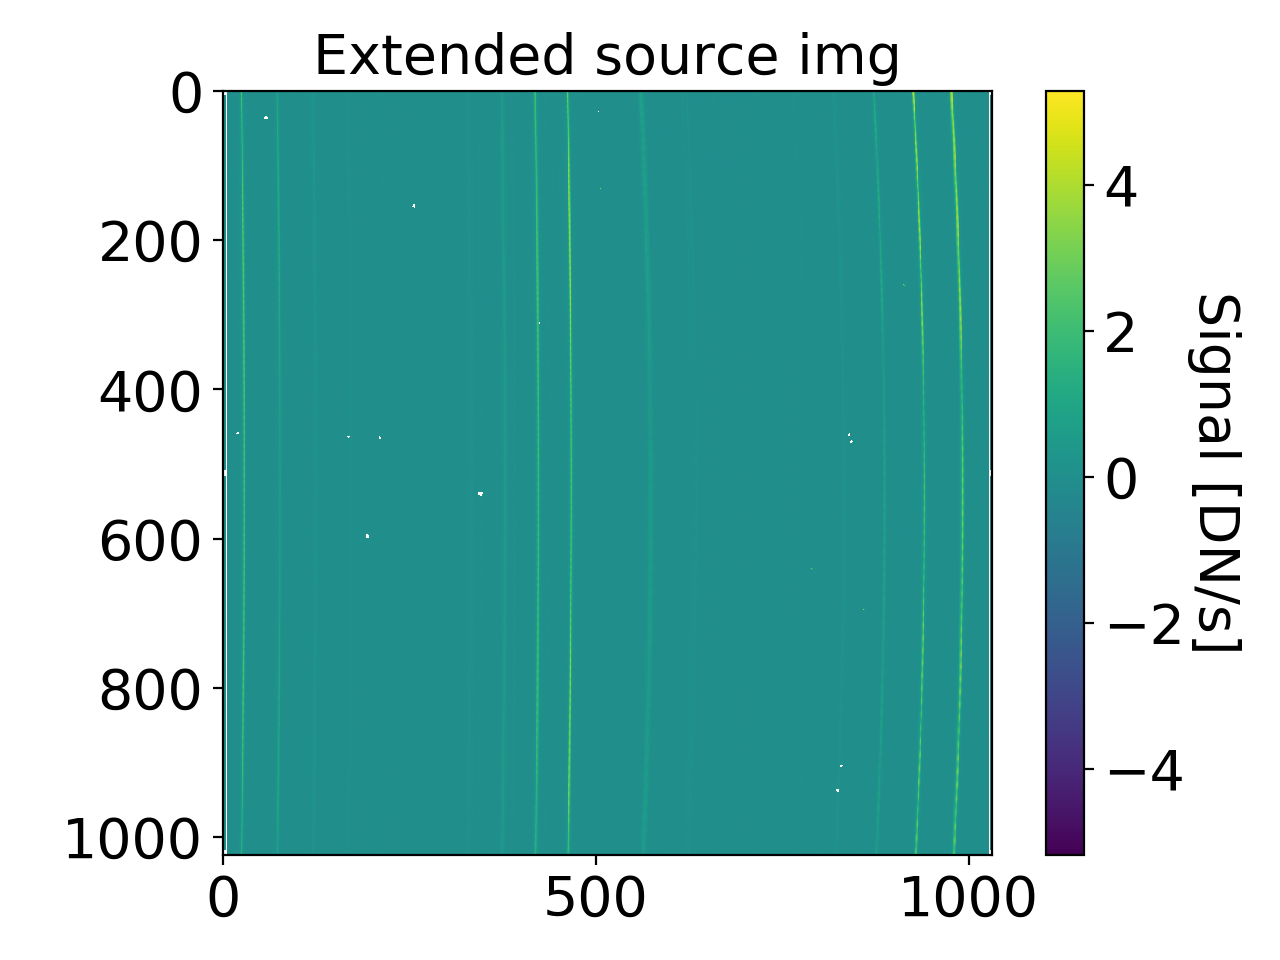

In [4]:
fig = plt.figure()
p = plt.imshow(ext_source_bkgsubtr)
plt.title("Extended source img")
cbar = fig.colorbar(p)
cbar.set_label('Signal [DN/s]', labelpad=20,rotation=270)
plt.tight_layout()

In [5]:
# plt.figure(figsize=(12,4))
# plt.step(ext_source_bkgsubtr[512,:],'b')
# plt.step(sliceMap[512,:]*10.,'g')
# plt.tight_layout()

In [6]:
nx = ext_source_bkgsubtr.shape[1]
ny = ext_source_bkgsubtr.shape[0]

In [7]:
# # Hack individual pixel values to test robustness to outliers
# ext_source_bkgsubtr[296:302,617:618]=9.

In [8]:
# Get rid of any nans
ext_source_bkgsubtr[np.isnan(ext_source_bkgsubtr)] = 0

# Get rid of any negative values
ext_source_bkgsubtr[ext_source_bkgsubtr<0] = 0

<IPython.core.display.Javascript object>


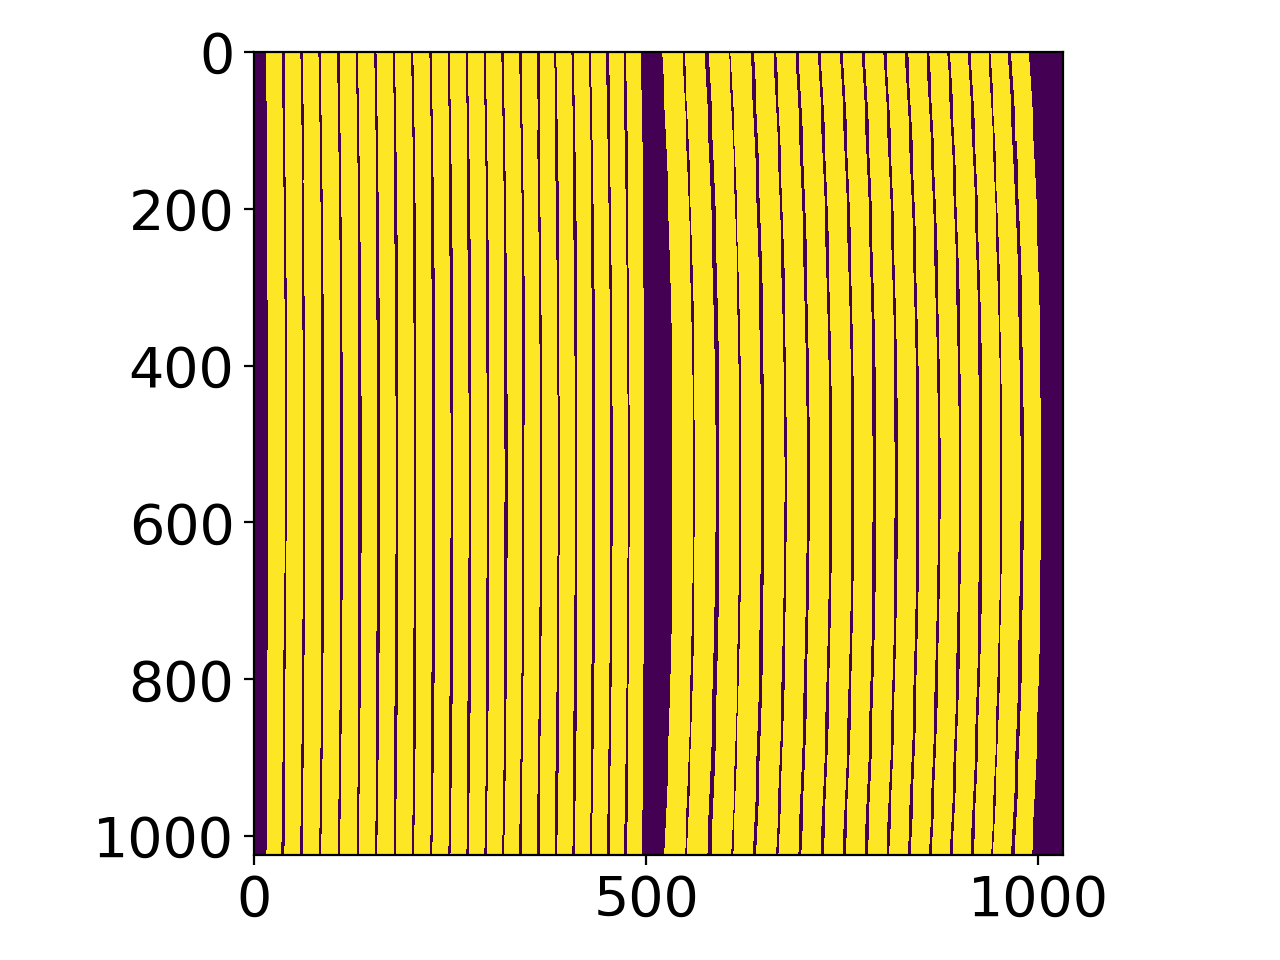

In [9]:
# Make a simple mask from the slice map for illustrative purposes
simplemask = np.full(det_dims,0)
simplemask[np.nonzero(sliceMap)] = 1.

plt.figure()
plt.imshow(simplemask)
plt.tight_layout()

In [10]:
# Define the ids of the individual slices
sliceid1=[111,121,110,120,109,119,108,118,107,117,106,116,105,115,104,114,103,113,102,112,101]
sliceid2=[201,210,202,211,203,212,204,213,205,214,206,215,207,216,217,209,208]
sliceid3=[316,308,315,307,314,306,313,305,312,304,311,303,310,302,309,301]
sliceid4=[412,406,411,405,410,404,409,403,408,402,407,401]

if band[0] in ['1','2']:
    sliceid1,sliceid2 = sliceid1,sliceid2
elif band[0] in ['3','4']:
    sliceid1,sliceid2 = sliceid4,sliceid3

nslice1,nslice2 = len(sliceid1),len(sliceid2)

In [11]:
# Make our mask for straylight purposes dynamically
mask = np.full(det_dims,0)

In [12]:
# At the edges and middle of the detector we'll select pixels at least 5 pixels away from the nearest slice to use in creating our model
optspace=5

<IPython.core.display.Javascript object>


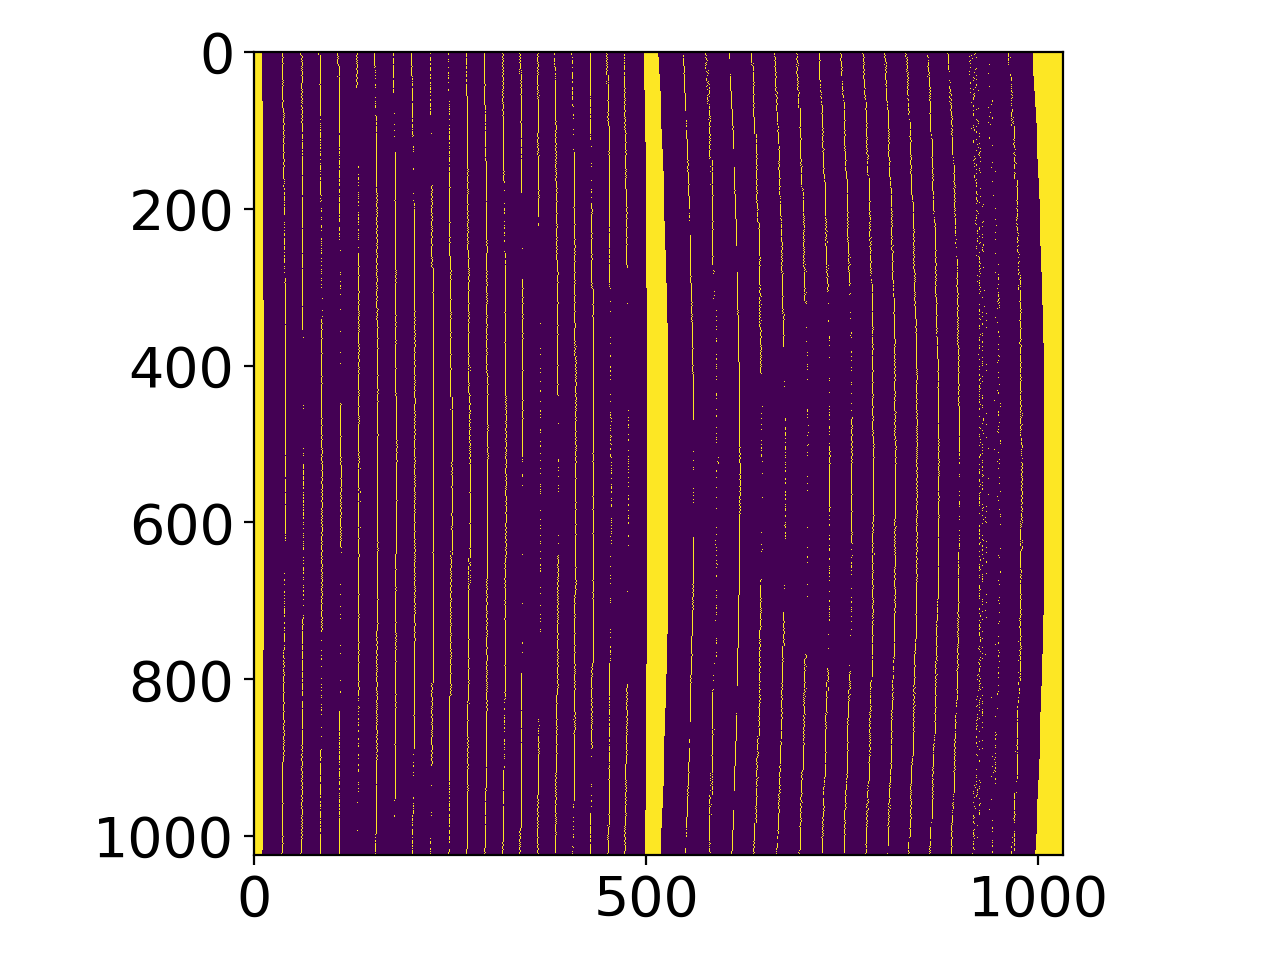

In [13]:
# In each gap between slices we'll select the pixel with the lowest flux
# Loop up rows
for i in range(ny):
    # Define temporary vector of slicenum along this row
    temp = sliceMap[i,:]
    # Left edge of detector
    indxr = np.where(temp == sliceid1[0])[0]
    mask[i,:indxr[0]-optspace] = 1
    # Left-half slices
    for j in range(nslice1-1):
        indxl = np.where(temp == sliceid1[j])[0]
        indxr = np.where(temp == sliceid1[j+1])[0]
        flux  = ext_source_bkgsubtr[i,indxl[-1]+1:indxr[0]-1] # signal in pixels between two stripes/slices on the detector
        indx  = np.where(flux == min(flux))[0]
        mask[i,indx[0]+(indxl[-1]+1)] = 1
    # Mid-detector pixels
    indxl = np.where(temp == sliceid1[-1])[0]
    indxr = np.where(temp == sliceid2[0])[0]
    mask[i,indxl[-1]+optspace:indxr[0]-optspace] = 1
    # Right-half slices
    for j in range(nslice2-1):
        indxl = np.where(temp == sliceid2[j])[0]
        indxr = np.where(temp == sliceid2[j+1])[0]
        flux  = ext_source_bkgsubtr[i,indxl[-1]+1:indxr[0]-1] # signal in pixels between two stripes/slices on the detector
        indx  = np.where(flux == min(flux))[0]
        mask[i,indx[0]+(indxl[-1]+1)] = 1
    # Right edge of detector
    indxl = np.where(temp == sliceid2[-1])[0]
    mask[i,indxl[-1]+optspace:] = 1

# resulting mask
plt.figure()
plt.imshow(mask)
plt.tight_layout()

In [14]:
# Mask the data
masked_data = ext_source_bkgsubtr*mask

<IPython.core.display.Javascript object>


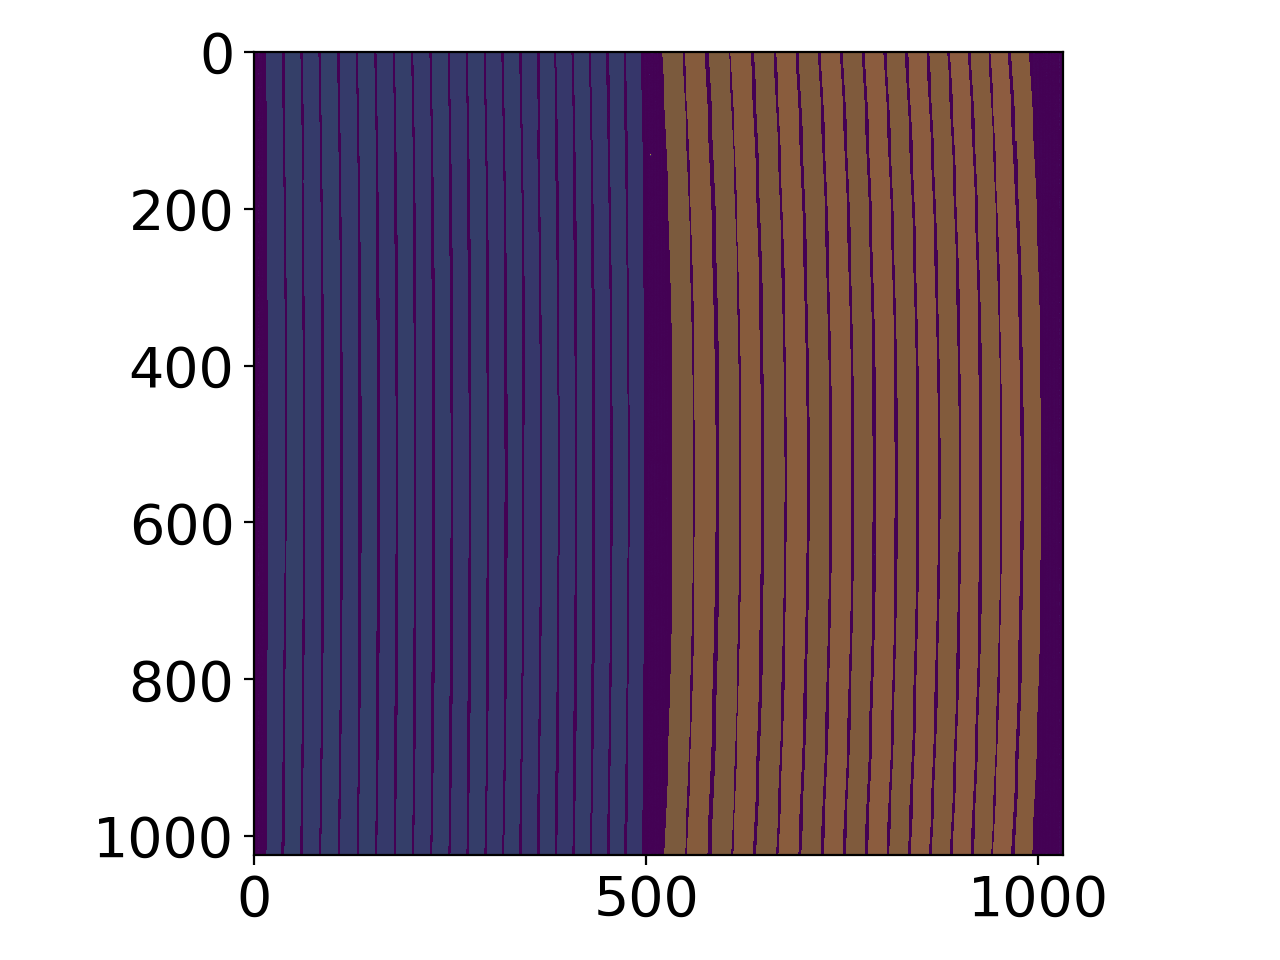

In [15]:
plt.figure()
plt.imshow(masked_data,zorder=0)
plt.imshow(sliceMap,alpha=0.4,zorder=1)
plt.tight_layout()

In [16]:
# Create the scattered light array
scatmodel_pass1 = np.full(det_dims,0.)
scatmodel_pass2 = np.full(det_dims,0.)
# Define pixel vectors
xvec = np.arange(nx)
yvec = np.arange(ny)

In [17]:
# Bspline the unmasked pixels looping along each row
for i in range(ny):
    indx  = np.where(mask[i,:] == 1)[0] # select only unmasked pixels
    thisx = xvec[indx]
    thisf = ext_source_bkgsubtr[i,indx]
    var = (ext_source_bkgsubtr_error[i,indx]**2)[~np.isnan(ext_source_bkgsubtr_error[i,indx])].sum()
#     var = np.var(thisf[~np.isnan(thisf)])
    w = np.full(len(thisx),1.0/var)
    
    everyn = 5
    len_thisx = len(thisx)
    nbkpts = (len_thisx / everyn)
    xspot = np.arange(nbkpts)*(len_thisx / (nbkpts-1))
    bkpt = thisx[xspot]
    bkpt = bkpt.astype(float)
    fullbkpt = bkpt.copy()
    
    t, c, k = splrep(thisx, thisf, w=w, task=-1, t=fullbkpt[1:-1])
    spline = BSpline(t, c, k, extrapolate=False)
    scatmodel_pass1[i,:] = spline(xvec) # expand spline to the full range of x values

In [18]:
# Get rid of nans:
scatmodel_pass1[np.isnan(scatmodel_pass1)] = 0

# Get rid of negative spline values
scatmodel_pass1[scatmodel_pass1<0] = 0

<IPython.core.display.Javascript object>


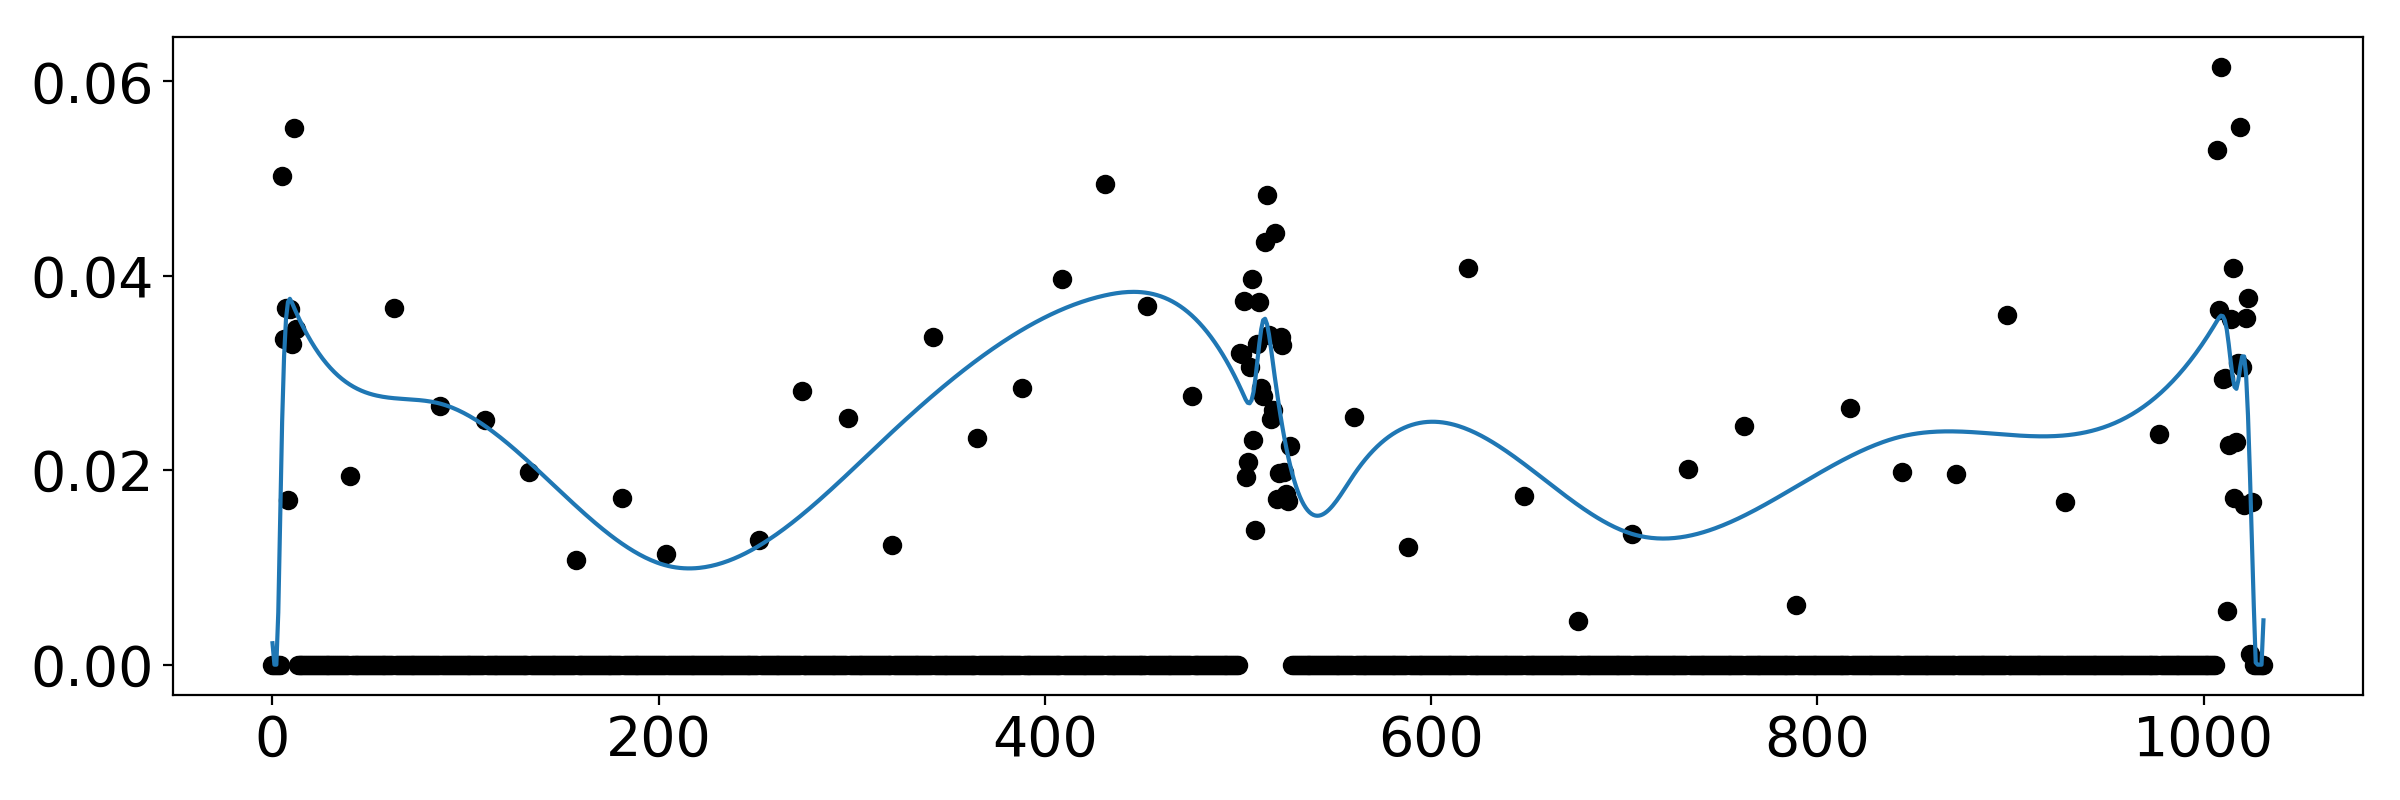

In [19]:
plt.figure(figsize=(12,4))
plt.plot(masked_data[512,:],'ko')
plt.plot(scatmodel_pass1[512,:])
# plt.plot(straylight_img[512,:])
plt.tight_layout()

In [20]:
# Bspline again in the Y direction
for i in range(nx):
    thisy = yvec[~np.isnan(scatmodel_pass1[:,i])]
    thisf = scatmodel_pass1[:,i][~np.isnan(scatmodel_pass1[:,i])]
#     var = (ext_source_bkgsubtr_error[:,i]**2)[~np.isnan(ext_source_bkgsubtr_error[:,i])].sum()
    var = np.var(thisf[~np.isnan(thisf)])
    w = np.full(len(thisy),1./var)
    
    everyn = 30
    len_thisy = len(thisy)
    nbkpts = (len_thisy / everyn)
    yspot = np.arange(nbkpts)*(len_thisy / (nbkpts-1))
    bkpt = thisy[yspot]
    bkpt = bkpt.astype(float)
    fullbkpt = bkpt.copy()
    
    t, c, k = splrep(thisy, thisf, w=w,task=-1, t=fullbkpt[1:-1]) # spline breakpoint every 30 values
    spline = BSpline(t, c, k, extrapolate=False)
    scatmodel_pass2[:,i] = spline(yvec)

<IPython.core.display.Javascript object>


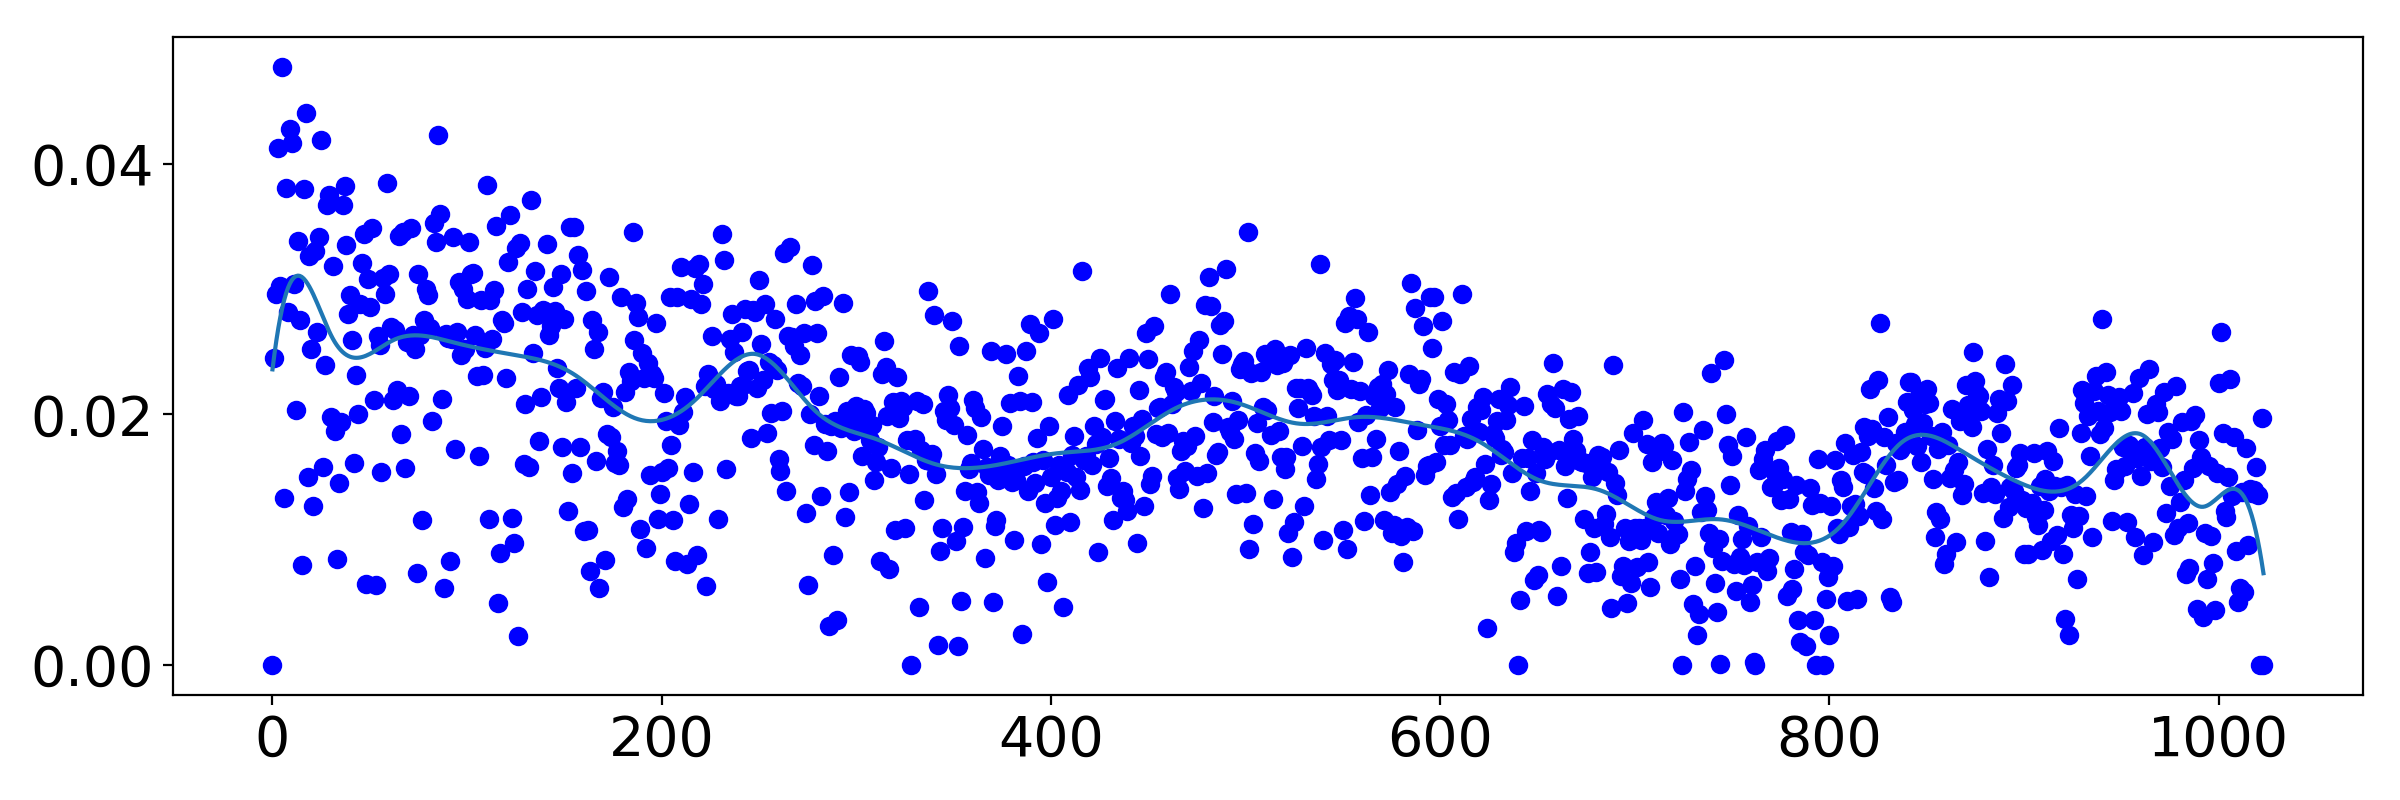

In [21]:
plt.figure(figsize=(12,4))
plt.plot(scatmodel_pass1[:,950],'bo')
plt.plot(scatmodel_pass2[:,950])
# plt.plot(straylight_img[:,950])
plt.tight_layout()

<IPython.core.display.Javascript object>


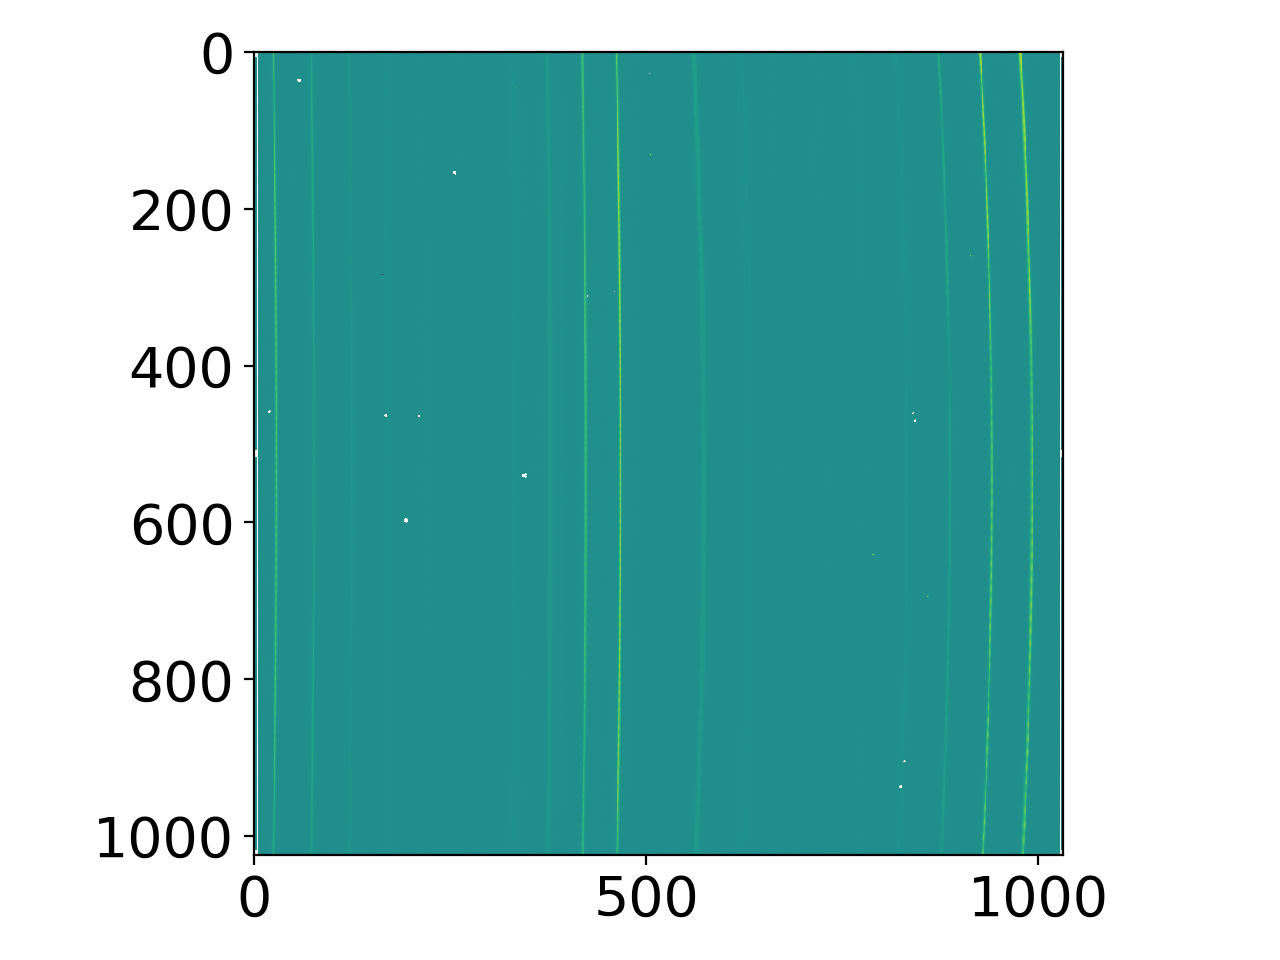

<IPython.core.display.Javascript object>


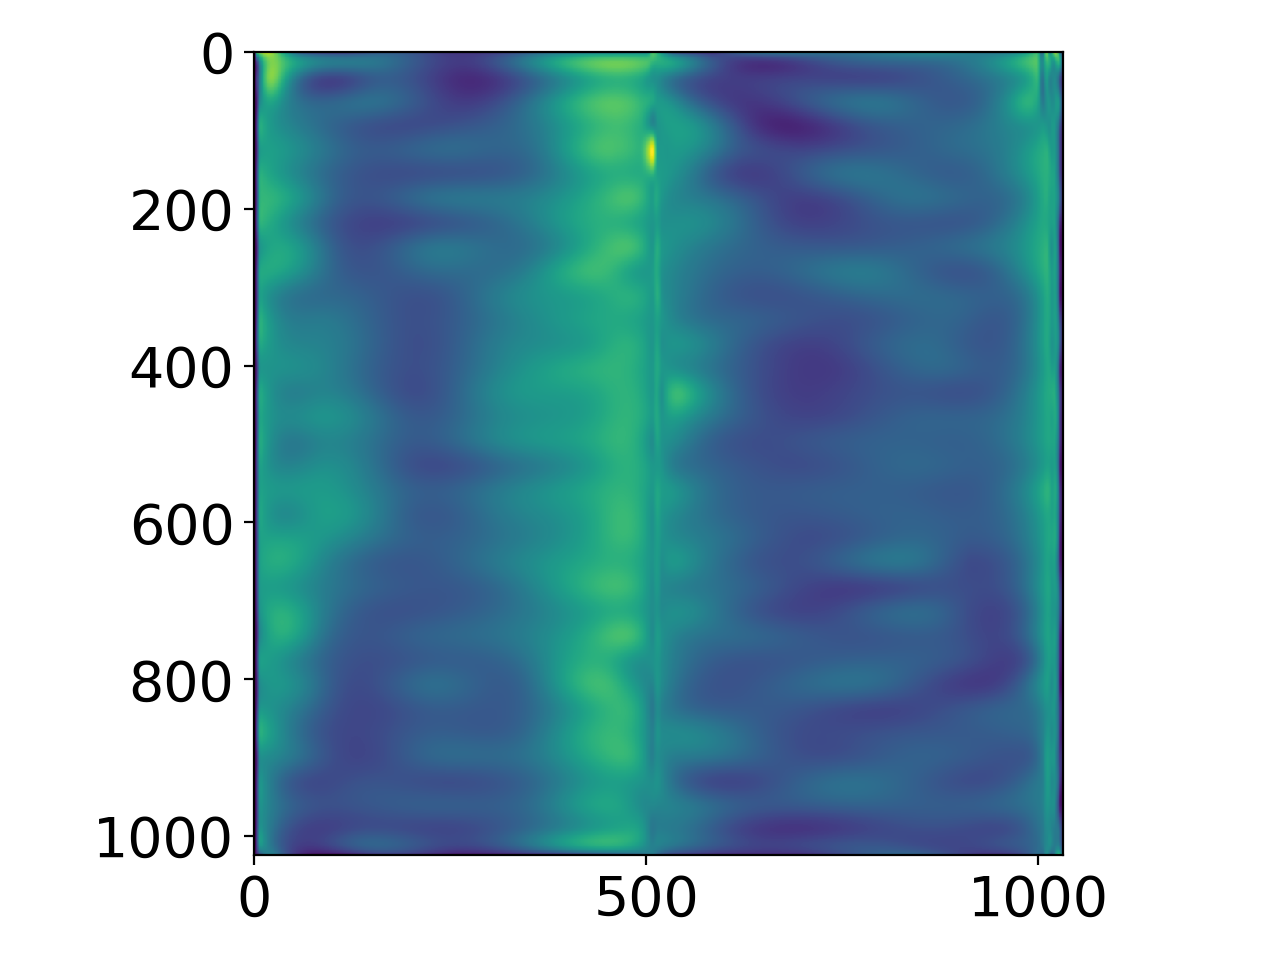

<IPython.core.display.Javascript object>


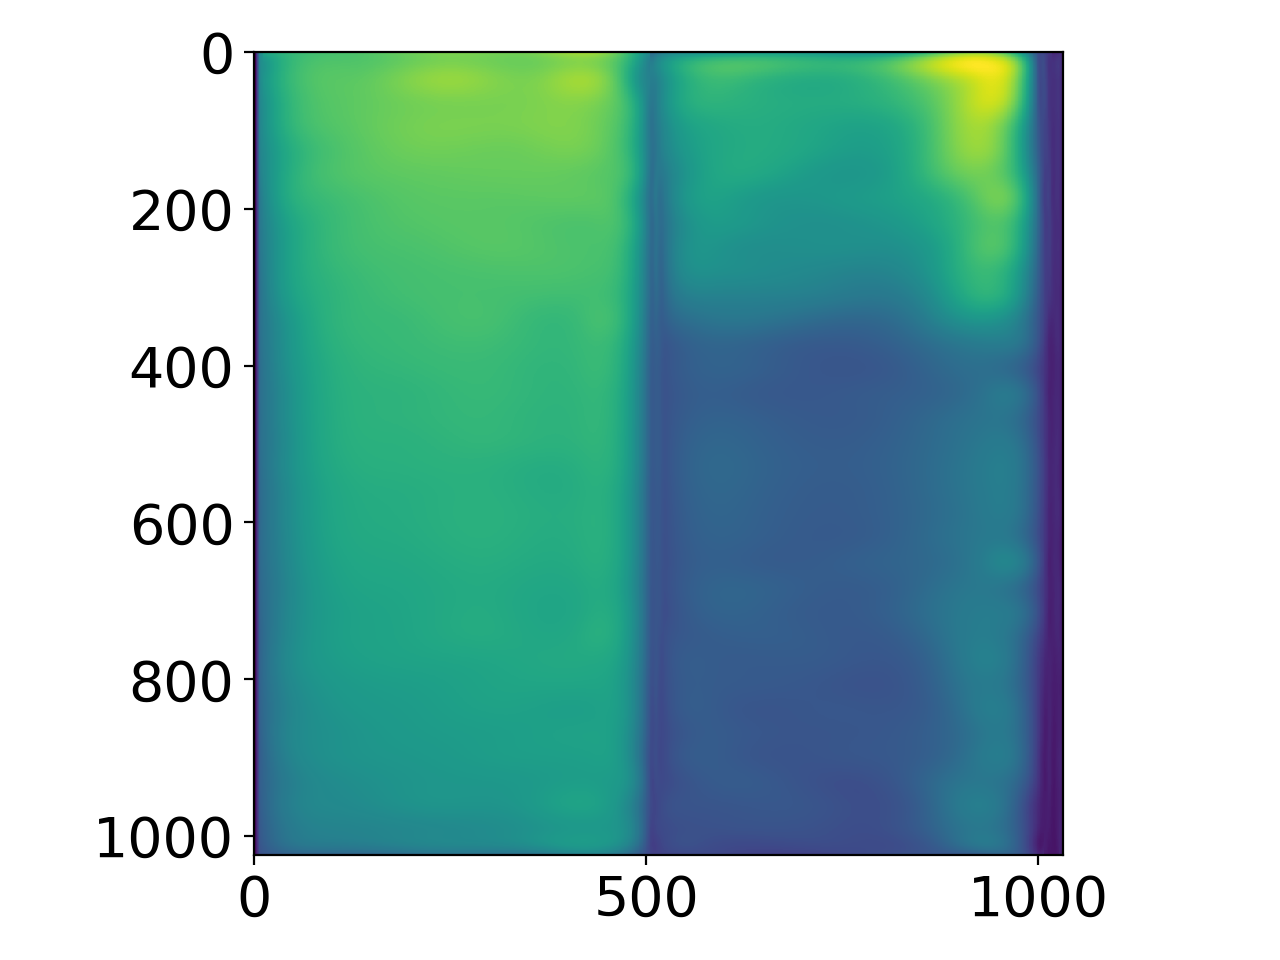

In [24]:
plt.figure()
plt.imshow(point_source_bkgsubtr)
plt.tight_layout()

plt.figure()
plt.imshow(scatmodel_pass2)
plt.tight_layout()

plt.figure()
plt.imshow(straylight_img)
plt.tight_layout()